<a href="https://colab.research.google.com/github/HauThierry/HauThierry/blob/main/D%C3%A9tection_anomalies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

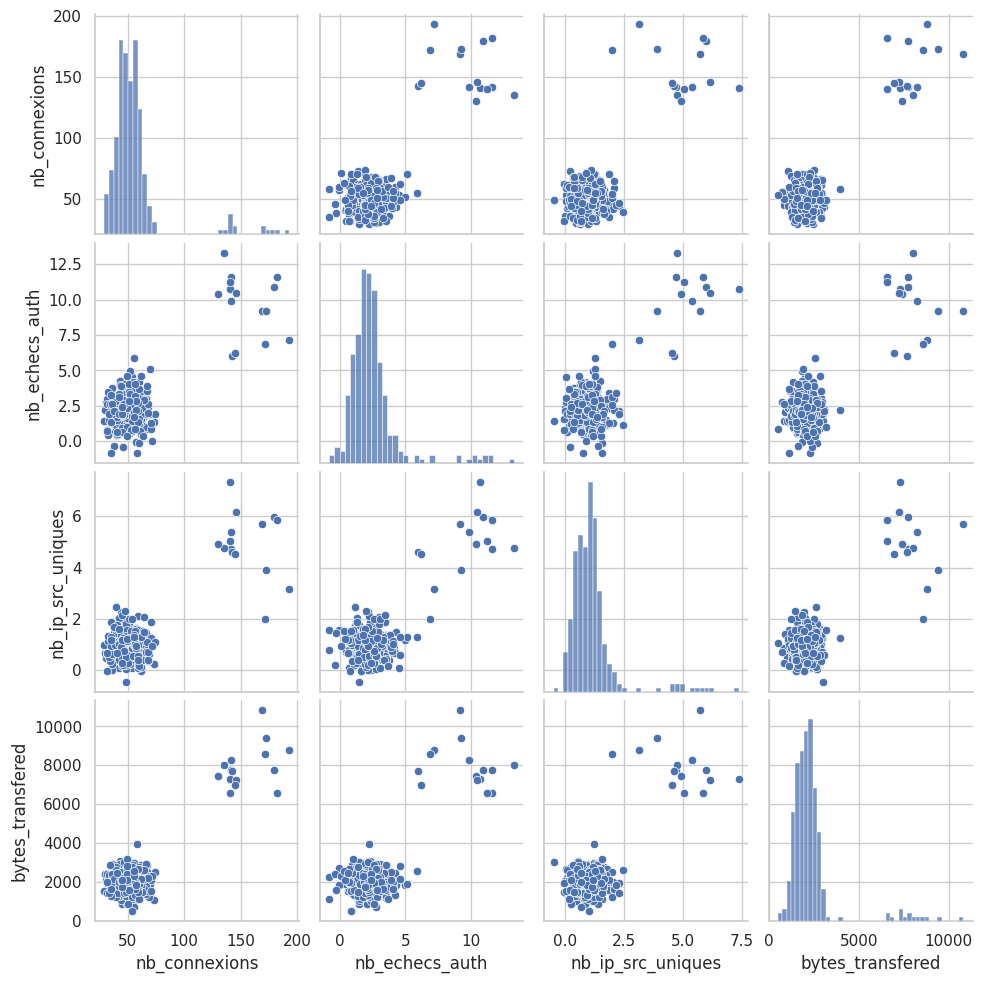

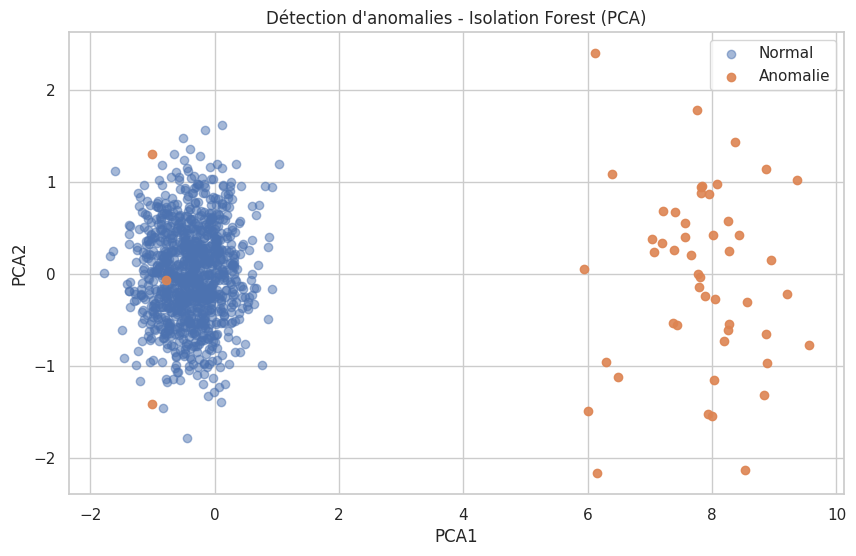

In [8]:
#0. Préambule
# Détection d’anomalies avec l’IA
## Isolation Forest & Local Outlier Factor (LOF)

# Objectifs :
#- Comprendre la détection d’anomalies non supervisée
#- Implémenter Isolation Forest et LOF
#- Appliquer ces méthodes à des données inspirées de logs cyber
#- Visualiser et interpréter les anomalies

# Contexte :
#- SOC / IDS
#- Logs réseau et systèmes
#- Données non labellisées


# 1. Imports & environnement

import numpy as np # numpy sert aux calculs numériques sous-jacents (vecteurs, matrices).
import pandas as pd # pandas permet de manipuler des données tabulaires (logs, CSV, datasets réseau).
import matplotlib.pyplot as plt # visualisation graphique.
import seaborn as sns

from sklearn.preprocessing import StandardScaler # Normalise les données (moyenne = 0, variance = 1).Évite qu’une feature domine les autres (ex : taille de paquet vs durée).
from sklearn.ensemble import IsolationForest # Détection globale d’anomalies par isolement.
from sklearn.neighbors import LocalOutlierFactor # Détection locale par densité.
# Ces deux méthodes sont non supervisées, donc adaptées aux logs sans labels fiables.
from sklearn.decomposition import PCA # PCA : réduction de dimension pour visualisation.

sns.set(style="whitegrid")

# 2. Génération d'un dataset "logs cyber" synthétique

np.random.seed(42)

# Données normales(comportement légitime)
normal_data = np.random.normal(loc=[50, 2, 1, 2000], scale=[10,1, 0.5, 500], size=(1000, 4))

# Anomalies (attaques, comportements suspects)
anomalies = np.random.normal(loc=[150, 10, 5, 8000], scale=[20, 2, 1, 1000], size=(50,4))

X = np.vstack((normal_data, anomalies))

columns = ["nb_connexions", "nb_echecs_auth", "nb_ip_src_uniques", "bytes_transfered"]

df = pd.DataFrame(X, columns=columns)

# 3. Exploration rapide des données

df.describe()
sns.pairplot(df.sample(300))
plt.show()

# Les anomalies ne sont pas évidentes visuellement en haute dimension.

# 4. Prétraitement : normalisation

scaler = StandardScaler() # crée l’outil de normalisation.
X_scaled = scaler.fit_transform(df) # o	apprend les statistiques (moyenne, écart-type),applique la transformation.

# 5. Isolation Forest
# 5.1 Entraînement du modèle

iso_forest = IsolationForest(n_estimators=200, contamination=0.05, random_state=42) # n_estimators : nombre d’arbres (plus = plus stable).contamination : proportion estimée d’anomalies (ici 5 %).random_state : reproductibilité scientifique.

df["if_label"] = iso_forest.fit_predict(X_scaled) # 1 → normal -1 → anomalie

df["if_score"] = -iso_forest.decision_function(X_scaled)

# 5.2 Résultats Isolation Forest

df["if_label"].value_counts()

# 6. Local Outlier Factor (LOF)
# 6.1 Entraînement

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05) # Compare chaque point à ses voisins proches. Très sensible aux anomalies contextuelles.

df["lof_label"] = lof.fit_predict(X_scaled)
df["lof_score"] = -lof.negative_outlier_factor_
# -1 → comportement rare localement
# 1 → comportement cohérent avec le voisinage


# 6.2 Résultats LOF

df["lof_label"].value_counts()

# 7. Comparaison Isolation Forest vs LOF

comparison = pd.DataFrame({"IsolationForest": df["if_label"],"LOF": df["lof_label"]})

comparison.head()

# IF -> anomalies globales
# LOF -> anomalies locales / contextuelles

# 8. Visualisation PCA (graphique explicatif)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
# On passe de N dimensions à 2.
# Objectif : voir les anomalies.


df["pca1"] = X_pca[:, 0]
df["pca2"] = X_pca[:, 1]

# PCA + Isolation Forest

plt.figure(figsize=(10,6))

plt.scatter(df[df["if_label"] == 1]["pca1"], df[df["if_label"] == 1]["pca2"], alpha=0.5,label="Normal")

plt.scatter(df[df["if_label"] == -1]["pca1"], df[df["if_label"] == -1]["pca2"], alpha=0.9, label="Anomalie")

plt.title("Détection d'anomalies - Isolation Forest (PCA)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.show()
# Les points isolés = candidats anomalies.

# 9. Analyse pédagogique des résultats (Markdown)
### Interprétation

#- Les points isolés correspondent à des comportements atypiques
#- Les anomalies ne sont pas toujours extrêmes
#- Certaines anomalies sont détectées par LOF mais pas par Isolation Forest

# Conclusion :
# → Les deux méthodes sont complémentaires.

# 10. Cas d’usage cybersécurité (Markdown)
### Cas d’usage SOC

# Isolation Forest :
# - Détection brute-force
# - Exfiltration volumineuse
# - Scans massifs

# LOF :
# - Attaques lentes (low & slow)
# - Comportements insiders
# - Déviations contextuelles

# Aucune méthode ne suffit seule.

# 11. Limites et bonnes pratiques
# - Pas de labels → validation humaine nécessaire
# - Faux positifs inévitables
# - Importance du feature engineering
# - Toujours contextualiser métier / SOC

# 12. Références
### Références

# - Chandola et al., *Anomaly Detection: A Survey*, ACM CS, 2009
# - Liu et al., *Isolation Forest*, IEEE ICDM, 2008
# - Breunig et al., *LOF*, ACM SIGMOD, 2000
# - Ring et al., *Survey of IDS Datasets*, Computers & Security
# - Scikit-learn documentation

# À retenir :
# - Détection d’anomalies ≠ classification
# - IF = rapide, scalable, global
# - LOF = contextuel, précis, coûteux
# - Visualisation indispensable
# - Humain toujours dans la boucle




